## Dynamic Time Warping to identify trends

#### Install tslearn package

In [1]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


#### Connect to the database and import packages

In [2]:
import getpass
import pandas as pd
from sklearn import preprocessing
import numpy as np
import os.path
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import copy
mypasswd = getpass.getpass()
username = 'cahvmr'
host = 'pgsql.dsa.lan'
database = 'caponl_22g3'
# Then connects to the DB
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

# SQLAlchemy Connection Parameters
postgres_db = {'drivername': 'postgres',
               'username': username,
               'password': mypasswd,
               'host': host,
               'database' :database}
engine = create_engine(URL(**postgres_db), echo=True)
connection_string = f"postgres://{username}:{mypasswd}@{host}/{database}"
%load_ext sql
%sql $connection_string 
del mypasswd

········


#### Import the countries csv to pare down the list

In [3]:
countries=pd.read_csv("/dsa/groups/capstonesp2022/online/group_3/M1/CountryCodesFinal.csv")
countries.head()

,short_name,alpha2_code,alpha3_code,numeric_code,iso3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Albania,AL,ALB,8,ISO 3166-2:AL
2,Algeria,DZ,DZA,12,ISO 3166-2:DZ
3,American Samoa,AS,ASM,16,ISO 3166-2:AS
4,Andorra,AD,AND,20,ISO 3166-2:AD


#### The process table function to generate a dataframe and identify the number of datapoints per country per metric

In [4]:
def process_table(in_table, year_f=1973, year_l=2019, use='keep'): #In table is the name of the database table you want to pull ("pop", "wdi", etc), year_f is the first year, year_l is the last year, and use=keep makes the default to reuse the existing per country per metric data
    sql='''Select * from WB_{}''' #setting the sql statement
    table=pd.read_sql(sql.format(in_table), engine, index_col='index') #pulling the sql statement while filling it in from the in_table variable
    table=table[(table['variable']>=year_f)&(table['variable']<=year_l)] #refining the table data to the years (could be incorporated into sql statement)
    table=countries.merge(table, how='inner', right_on='Country Code', left_on='alpha3_code') #implementing the countries table to remove unwanted entities
    if os.path.isfile('/dsa/groups/capstonesp2022/online/group_3/Comp_Recs/{}_comps.csv'.format(in_table)) and use=='keep': #if statement to determine if existing data should be used
        catcount=pd.read_csv('/dsa/groups/capstonesp2022/online/group_3/Comp_Recs/{}_comps.csv'.format(in_table))
    else:
        catcount=pd.DataFrame(columns=['Country', 'Metric', 'First', 'Last', 'Total', 'Same', 'NaN']) #creating the catcount dataframe
        for u in table['Country Name'].unique(): #iterate through each country
            for x in table.iloc[:,8:].columns: #iterate through each column in each country
                a=0 #create a counter
                nums=[] #create an empty list to put metric data in
                if sum(np.isnan(table[table['Country Name']==u][x]))==len(table[table['Country Name']==u][x]): #Comparing the number of NaNs with the length to minimize effort on NaN records
                    catcount=catcount.append({'Country':u, 'Metric':x, 'First':0, 'Last':0, 'Total':0, 'Same':True, 'NaN':True}, ignore_index=True)

                elif is_same(table[table['Country Name']==u][x]): # Finding metrics where the numbers are all the same and minimizing effort
                    catcount=catcount.append({'Country':u, 'Metric':x, 'First':0, 'Last':0, 'Total':0, 'Same':True, 'NaN':False}, ignore_index=True)

                else: #Anything that is not NaN and the column isn't the same throughout gets processed
                    for y in table[table['Country Name']==u][x]: #Going cell by cell in the column
                        if np.isnan(y)==False: #If the value is not NaN, mark the position of the value with the counter
                            nums.append(a)
                        a+=1 #increment the counter whether it is or is not NaN
                    catcount=catcount.append({'Country':u, 'Metric':x, 'First':min(nums), 'Last':max(nums), 'Total':len(nums), 'Same':False, 'NaN':False}, ignore_index=True) #write the column data after it has been iterated through
        catcount.to_csv('/dsa/groups/capstonesp2022/online/group_3/Comp_Recs/{}_comps.csv'.format(in_table)) #write the final data to a csv so it can be used again
    inout=[] #create an empty list for finding columns that are just 0s and 1s (they don't offer enough resolution to be useful)
    
    for row in range(len(catcount['Country'])): #iterate through the df by row
        if {a for a in table[(table['Country Name']==catcount['Country'][row]) & (table['variable']>=year_f) & (table['variable']<=year_l)][catcount['Metric'][row]]}==({0} or {0,1}): #checking each column to see if they're in the set 0 or set 0,1
            inout.append('out') #out means reject because it is in the set 0 or set 0,1 
        else:
            inout.append('in') #in means keep the data because it's varied
    catcount['Generic']=inout #writing the column "generic" to identify whether it's generic data (whether to keep or reject)
    
    return table, catcount #returning the two entities - data df and category count df

#### A simple function to test if the column is all the same

In [5]:
def is_same(s): 
    a = s.to_numpy() #casting the input s to a numpy array and calling it a
    return (a[0] == a).all() #checking if the first value of a is equal to the rest of a

#### A simple function to look up the number of a metric by name

In [6]:
def met_lookup(comps, met):
    return np.where(comps[comps['Total']>=comps['Total'].max()]['Metric'].unique()==met)[0][0] #Only metrics which have at least one full dataset (per country) are included in the list- this filters to the list then returns the number for the given metric

In [ ]:
#### A function to build a dataframe of the chosen countries and metric which closeness cores between all eligible entities

In [7]:
def table_comps(met_no, record, rec_nos, table): #met no is the metric number (found through met lookup), record is the list of complete datasets for the given metric(created in process table), rec_nos is the count for a full dataset, and table is the data df (created in process table) 
    cut=record[record['Total']>=rec_nos] #filtering out all partial datasets
    recs=pd.DataFrame() #creating a new df for evaluating records to keep
    for country in cut[(cut['Generic']=='in')&(cut['Same']==False)&(cut['NaN']==False)&(cut['Metric']==cut['Metric'].unique()[met_no])]['Country']: #iterating through the countries and filtering out all NaN, generic, or single-value columns for the given metric
        recs=recs.append(table[(table['Country Name']==country)].loc[:,['Country Name', 'variable', cut['Metric'].unique()[met_no]]]) #Writing all records that fit the criteria
    scores=pd.DataFrame() #creating a new df for the final comparison scores
    for a in range(len(recs['Country Name'].unique())): #Working down the rows in the recs df we made and assigning the first row a
        for b in range(len(recs['Country Name'].unique())): #Working down the same rows to compare each
            if a!=b and a<b: #skipping if a and b are the same row or if a is greater than b (these would be duplicates captured when b was greater than a)
                x=recs[recs['Country Name']==recs['Country Name'].unique()[a]][cut['Metric'].unique()[met_no]]#designating the x values to compare
                y=recs[recs['Country Name']==recs['Country Name'].unique()[b]][cut['Metric'].unique()[met_no]]#designating the y values to compare
                scores=scores.append({'Country1':recs['Country Name'].unique()[a], 'Country2':recs['Country Name'].unique()[b], 'Closeness':dtw(x,y), 'Metric':cut['Metric'].unique()[met_no]}, ignore_index=True) #running the dtw function on x and y values
    scores=scores.sort_values('Closeness').reset_index(drop=True) #sorting the values by closeness and reseting the index
    return scores #returning the scores

#### A function to create a correlation matrix of any metrics which have at least one full dataset (per country) and append the actual metric definitions

In [8]:
def corr_defins(rec_nos): #only input is the minimum number of records to target
    corr=table.loc[:,comps[comps['Total']>=rec_nos]['Metric'].unique()].corr()  #filtering the table df (created in process table) using the complete records df (created in process table) to only include metrics that have at least one full dataset
    dict=pd.read_csv("../GroupProducts/Milestone1/Indicator_Dict.csv") #reading in the definition csv
    corr2=corr.merge(dict, how='left', left_index=True, right_on='Indicator Code').reset_index(drop=True) #merging the definitions on the metrics
    return corr2 #returning the completed df

#### A function to graph the results of line comparisons

In [9]:
def graph_comps(rec, met_no, record, comparison): #rec is which pair (by row) to graph
    cut=comps[comps['Total']>=comps['Total'].max()] #using the same list of full datasets for consistency
    plt.plot(table[(table['Country Name']==eval(comparison)['Country1'][rec])]['variable'], table[(table['Country Name']==eval(comparison)['Country1'][rec])][cut['Metric'].unique()[met_no]], color='red', label=eval(comparison)['Country1'][rec]) #plotting the years and datapoints for the chosen country and the chosen metric for the a country
    plt.plot(table[(table['Country Name']==eval(comparison)['Country2'][rec])]['variable'], table[(table['Country Name']==eval(comparison)['Country2'][rec])][cut['Metric'].unique()[met_no]], color='orange', label=eval(comparison)['Country2'][rec]) #plotting the years and datapoints for the chosen country and the chosen metric for the b country
    plt.legend() 
    plt.show()

#### A function to compare entire lines' closeness

In [10]:
def close(table_in, met_no): #input is the name of the table (to pass to process table) and metric number to pass to the table_comps function
    table, comps=process_table(table_in) #calling the process table function to pull the desired data and locate complete records
    close1=table_comps(met_no, comps, comps['Total'].max(), table) #calling the table_comps function to computer the closeness scores
    return close1 #returning the closeness score df

#### A function to locate converging (or diverging if you reverse sort) lines by identifying their closeness pre-2000 and their closeness after 2000 then subtracting the pre value from the post value

In [11]:
def divergence(table_in, met_no): #input is the name of the table (to pass to process table) and metric number to pass to the table_comps function
    table, comps=process_table(table_in, year_l=2000, use=1) #Processing table with the parameters to only use pre-2000 data and, since we're not using the entire dataset, use is not "keep" so that everything is calculated new
    close1=copy.deepcopy(table_comps(met_no, comps, comps['Total'].max(), table)) #running the table comps to get scores but using deepcopy to save those values for later comparison
    table, comps=process_table(table_in, year_f=2001, use=1) #Processing table with the parameters to only use post-2001 data and, since we're not using the entire dataset, use is not "keep" so that everything is calculated new
    met=met_lookup(comps, close1['Metric'].unique()[0]) #Since the number of complete metrics available change in different year groups, it looks up the first value by name in the second dataset and uses that value
    close2=table_comps(met, comps, comps['Total'].max(), table) #getting the scores for post-2001 lines
    close_both=pd.merge(close1, close2, on=['Country1', 'Country2']) #merging the scores together in the close_both dataframe
    close_both['convergence']=close_both['Closeness_x']-close_both['Closeness_y'] #calculating the difference of the two lines so the greatest change is identified
    close_both=close_both.sort_values('convergence', ascending=False).reset_index(drop=True) #sorting the values by this difference and reseting index
    return close_both #returning the close_both dataframe

#### First processing of the tables. This is only really useful to identify the potential metrics. Default for process table is all data

In [12]:
table_in='pop' #naming the database table to use. Options are 'pop', 'gender', 'spi', 'wdi', and 'hnp'
table, comps=process_table(table_in) #processing it

2022-02-02 16:25:25,746 INFO sqlalchemy.engine.base.Engine select version()
2022-02-02 16:25:25,747 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:25:25,749 INFO sqlalchemy.engine.base.Engine select current_schema()
2022-02-02 16:25:25,749 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:25:25,752 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2022-02-02 16:25:25,752 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:25:25,754 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2022-02-02 16:25:25,754 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:25:25,756 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2022-02-02 16:25:25,756 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:25:25,758 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

#### Call to the lookup function using the complete records df and the target metric

In [14]:
met_lookup(comps, 'SPDYNTFRTIN')

19

#### Call the table and process it for general line closeness

In [15]:
table_in="pop"
close=close(table_in, 19) #only the metric number needs changed
table, comps=process_table(table_in)

2022-02-02 16:27:53,353 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-02-02 16:27:53,354 INFO sqlalchemy.engine.base.Engine {'name': 'Select * from WB_pop'}
2022-02-02 16:27:53,356 INFO sqlalchemy.engine.base.Engine Select * from WB_pop
2022-02-02 16:27:53,357 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:33:04,446 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-02-02 16:33:04,447 INFO sqlalchemy.engine.base.Engine {'name': 'Select * from WB_pop'}
2022-02-02 16:33:04,709 INFO sqlalchemy.engine.base.Engine Select * from WB_pop
2022-02-02 16:33:04,710 INFO sqlalchemy.engine.base.Engine {}


#### Calling the function to find converging lines

In [18]:
table_in="pop"
close_both=divergence(table_in, 19)
table, comps=process_table(table_in, use=1)

2022-02-02 16:37:29,694 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-02-02 16:37:29,695 INFO sqlalchemy.engine.base.Engine {'name': 'Select * from WB_pop'}
2022-02-02 16:37:29,708 INFO sqlalchemy.engine.base.Engine Select * from WB_pop
2022-02-02 16:37:29,709 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:48:51,757 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-02-02 16:48:51,758 INFO sqlalchemy.engine.base.Engine {'name': 'Select * from WB_pop'}
2022-02-02 16:48:52,182 INFO sqlalchemy.engine.base.Engine Select * from WB_pop
2022-02-02 16:48:52,183 INFO sqlalchemy.engine.base.Engine {}
2022-02-02 16:59:53,710 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace 

#### Graphing the desired row of the desired table

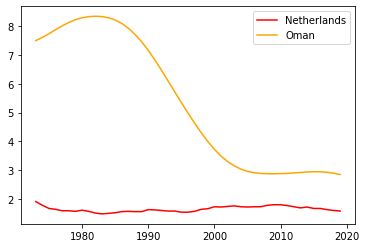

In [23]:
rec=1 #Select which row to graph
comparison='close_both' #choose "close" for two lines' closeness ("close" df) or "close_both" for lines that converge(diverge if you reverse sort)


if comparison=='close': #A simple if function to set the "Metric" reference to "Metric_x" if needed
    metric="Metric"
else:
    metric="Metric_x"
met=met_lookup(comps, eval(comparison)[metric].unique()[0]) #Metric is parsed from the table called above
graph_comps(rec, met, comps, comparison)